[**Speech Accent Arhive Mandarin Subcorpus**](https://accent.gmu.edu/browse_language.php?function=find&language=mandarin)

## Weighted Convolution Relevance ##

In [1]:
import transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
import torch
#from torch import nn
import librosa
import librosa.display
from IPython.display import Audio
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jiwer
from scipy import signal

print(transformers.__version__)

4.28.0.dev0


In [2]:
### SET PATH AND CUDA ###
PATH_TO_DATA = "/home/sl12/SAA/recordings/chopped_recordings/slabs/mandarin33_slabs.mp3"
DEVICE = "cuda:1"

In [3]:
### LOAD AUDIO ###
input_audio, sr = librosa.load(PATH_TO_DATA, sr=16000)
Audio(input_audio, rate=16000)

/home/sl12/.conda/envs/speech2image/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [4]:
### LOAD TRANSCRIPT ###
transcription = "five thick slabs of blue cheese"

In [5]:
### LOAD PROCESSOR AND MODEL ###
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

### LOAD AUDIO INPUTS ###
# inputs = feature_extractor(input_audio, sampling_rate=16000, return_tensors="pt").input_values.to(DEVICE)
inputs = feature_extractor(input_audio, sampling_rate=16000, return_tensors="pt")
inputs["input_values"] = inputs["input_values"].cuda(device=1)

### PASS THROUGH MODEL ###
output = model(**inputs, output_hidden_states=True)

### PREDICTED TRANSCRIPTION ###
logits = output.logits
predicted_ids = torch.argmax(logits[0], dim=-1)

outputs = tokenizer.decode(predicted_ids, output_word_offsets=True, output_char_offsets=True)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
outputs[0]

'FIVE THICK SLAPS OF BLUE CHEESE'

In [7]:
char_offsets = [
    {
        "char": d["char"],
        "start": d["start_offset"],
        "end": d["end_offset"],
    }
    for d in outputs.char_offsets
]
word_offsets = [
    {
        "word": d["word"],
        "start": d["start_offset"],
        "end": d["end_offset"],
    }
    for d in outputs.word_offsets
]

In [8]:
char_offsets[11:16] #char

[{'char': 'S', 'start': 47, 'end': 49},
 {'char': 'L', 'start': 51, 'end': 52},
 {'char': 'A', 'start': 56, 'end': 57},
 {'char': 'P', 'start': 59, 'end': 60},
 {'char': 'S', 'start': 62, 'end': 64}]

In [9]:
word_offsets

[{'word': 'FIVE', 'start': 16, 'end': 29},
 {'word': 'THICK', 'start': 35, 'end': 44},
 {'word': 'SLAPS', 'start': 47, 'end': 64},
 {'word': 'OF', 'start': 67, 'end': 69},
 {'word': 'BLUE', 'start': 73, 'end': 83},
 {'word': 'CHEESE', 'start': 87, 'end': 103}]

In [10]:
print(len(output.hidden_states[1][0][1])) # sequence length × hidden size

8024


In [11]:
### CALCULATE RELEVANCE PART 1: CALCULATE GRADIENT ###
score = torch.transpose(logits, 1, 2)
score_argmax_col, _ = torch.max(score, dim=1) # 1 * token length
grad_list = []
for i in range(56, 58): # Calcualte graident for each
    grad_token = torch.autograd.grad(score_argmax_col[0][i], output.hidden_states[1], retain_graph=True)
    grad_list.append(grad_token[0])
print(len(grad_list))

2


In [12]:
### CALCULATE RELEVANCE PART 2: GET FIRST CNN LAYER ###
kernel = None
for i, param in enumerate(model.wav2vec2.feature_extractor.conv_layers[0].parameters()):
    # print(i, param.shape) # index, param
    kernel = param
    break
print(kernel.shape)
print(kernel[0][0])

torch.Size([512, 1, 10])
tensor([-0.0993, -0.0391,  0.1550,  0.0334,  0.3879, -0.1312,  0.0720,  0.2163,
         0.0232,  0.2776], device='cuda:1', grad_fn=<SelectBackward0>)


In [13]:
### ZERO PAD ###
last_dim_pad = (0, 390) # first index for front padding, second index for end padding
padded_out = torch.nn.functional.pad(kernel, last_dim_pad, "constant", 0)  # effectively zero padding
print(padded_out.shape)

torch.Size([512, 1, 400])


In [14]:
score = torch.transpose(logits, 1, 2)
score_argmax_col, _ = torch.max(score, dim=1) # 1 * token length
grad_list = []
for i in range(56, 58): # Calcualte graident for each
    grad_token = torch.autograd.grad(score_argmax_col[0][i], output.hidden_states[1], retain_graph=True)
    print(grad_token[0].shape)
    grad_list.append(grad_token[0])
print(len(grad_list))
print(grad_list[0][0])

torch.Size([1, 512, 8024])
torch.Size([1, 512, 8024])
2
tensor([[ 0.0119, -0.0022,  0.0032,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0013,  0.0003,  0.0031,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0139,  0.0177,  0.0278,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0075, -0.0127, -0.0171,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0177,  0.0041,  0.0020,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0146,  0.0139,  0.0182,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:1')


In [15]:
relu = torch.nn.ReLU()

In [16]:
relevance_list = []
rel_sum = torch.zeros(output.hidden_states[1].shape[1], output.hidden_states[1].shape[0], output.hidden_states[1].shape[2])
for i in range(len(grad_list)):
    relevance_before_permute = torch.mul(grad_list[i], output.hidden_states[1])
    relevance = relu(torch.permute(relevance_before_permute, (1, 0, 2)))
    relevance_list.append(relevance)
print(len(relevance_list))
print(relevance_list[0].shape)
print(relevance_list[0][0])

2
torch.Size([512, 1, 8024])
tensor([[2.9049e-07, 0.0000e+00, 7.8161e-08,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:1', grad_fn=<SelectBackward0>)


In [17]:
### ADD UP RELEVANCE ###
rel_sum = torch.zeros(output.hidden_states[1].shape[1], output.hidden_states[1].shape[0], output.hidden_states[1].shape[2]).cuda(device=1)
for i in range(len(grad_list)):
    relevance_before_permute = torch.mul(grad_list[i], output.hidden_states[1])
    relevance = torch.permute(relevance_before_permute, (1, 0, 2))
    rel_sum += relevance
relu_rel_sum = relu(rel_sum)
print(relu_rel_sum.shape)

torch.Size([512, 1, 8024])


In [18]:
### ADD OVER 512 DIMENSIONS ###
conv_sum_list = []
log_conv_sum_list = []
length = int(len(padded_out[0][0])/2)
for idx in range(output.hidden_states[1].shape[1]):
    conv_sum = torch.zeros(length, relu_rel_sum.shape[2]).cuda(device=1)
    log_conv_sum = torch.zeros(length, relu_rel_sum.shape[2]).cuda(device=1)
    ft_conv = torch.fft.fftshift(torch.fft.fft(padded_out[idx][0])) # dimension of padded_out = [512, 1, 400]
    ft_conv2 = torch.split(ft_conv, int(len(padded_out[0][0])/2))[1][None, :]
    log_mag = 20*torch.log10(torch.abs(ft_conv2))
    mag = torch.abs(ft_conv2)
    log_mag_tmp = torch.transpose(log_mag, 0, 1).cuda(device=1)
    log_col = torch.flip(log_mag_tmp, [0, 1]).cuda(device=1)
    mag_tmp = torch.transpose(mag, 0, 1).cuda(device=1)
    col = torch.flip(mag_tmp, [0, 1]).cuda(device=1)
    row = relu_rel_sum[idx].cuda(device=1)
    log_tmp = torch.matmul(log_col,row).cuda(device=1)
    tmp = torch.matmul(col,row).cuda(device=1)
    log_conv_sum += log_tmp
    conv_sum += tmp
    conv_sum_list.append(conv_sum)
    # print(conv_sum)
    log_conv_sum_list.append(log_conv_sum)
    # print(log_conv_sum)
print(len(conv_sum_list))

512


In [19]:
print(conv_sum_list[0].shape)
print(len(conv_sum_list))

torch.Size([200, 8024])
512


In [20]:
log_final = torch.zeros(length, relu_rel_sum.shape[2]).to(DEVICE)
final = torch.zeros(length, relu_rel_sum.shape[2]).to(DEVICE)
for i in range(512):
    log_final += log_conv_sum_list[i]
    final += conv_sum_list[i]
print(final.shape)

torch.Size([200, 8024])


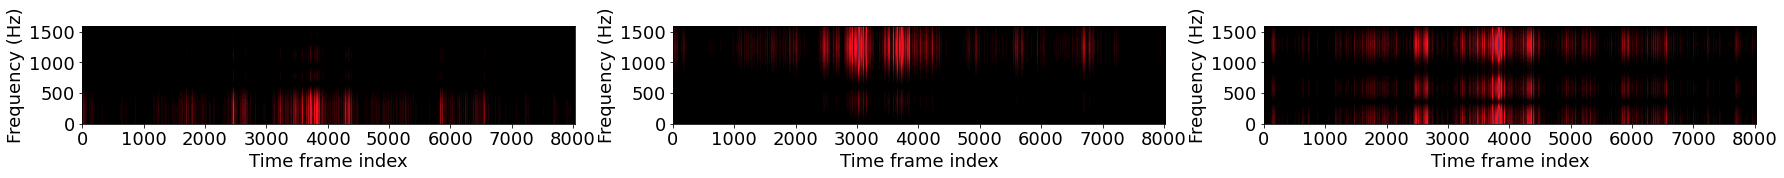

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 3))
subidx = 0
conv_filter = [13, 23, 0] # examples of lpf, hpf, bpf from 512 channels
for n, k in enumerate(conv_sum_list):
    if subidx == 3: break
    elif n in conv_filter:
        # add a new subplot iteratively)
        ax = plt.subplot(1, 3, conv_filter.index(n)+1)
        plt.imshow(k.cpu().detach().numpy(), cmap="gist_stern", extent=[0,len(output.hidden_states[1][0][1]),0,1600], aspect=1) #, extent=[0,12036,0,8000], aspect=0.5
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel('Time frame index', fontsize=18)
        plt.ylabel('Frequency (Hz)', fontsize=18)
        subidx += 1
plt.show()